# CIDS-Sim with Non-IID data with Heterogeneous Dataset

Federated Learning involves collaboration among multiple clients to learn from decentralized data. In the context of CIDS, each client acts as a detector unit distributed across various networks, while the central server, responsible for aggregating the models, functions as the correlation unit. This research employs a non-IID (Non-Independent and Identically Distributed) data setting to distribute data across different clients. The Federated Averaging (FedAvg) algorithm is used to aggregate models from multiple clients.

## CIDS Architecture

<p align="center">
    <img width="699" alt="image" src="https://github.com/aulwardana/CIDS-Sim/blob/main/images/arch_CIDS-Sim_Non-IID.png?raw=true">
</p>


## Dataset

This simulator will use a Coordinated Attack dataset with [CICFlowMeter (CIC) features](https://www.unb.ca/cic/datasets/ids-2018.html).  For the CIC dataset, please download from [here](https://www.kaggle.com/luminardata).

## Other Information

The simulator will run binary classification, so the traffic will labeled as normal (0) or anomaly (1)

---

First, import libraries

---

In [1]:
import numpy as np
import pandas as pd
import time
import psutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Recall, Precision

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

2024-11-13 08:03:02.750792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 08:03:02.760634: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 08:03:02.778531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 08:03:02.807452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 08:03:02.816217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 08:03:02.837369: I tensorflow/core/platform/cpu_feature_gu

---

Load Coordinated Attack dataset. We are using ".parquet" file for faster reading data.

Use heterogeneous and multi network dataset from CoAt-Set to run this simulation.
The dataset used the CIC feature for heterogeneous and multi network dataset in the Non-IID scenario.
Here is the list of the dataset:
1. `CoAt_CIC-BoT-IoT-V2.parquet`
2. `CoAt_CIC-IDS2017-V2.parquet`
3. `CoAt_CIC-ToN-IoT-V2.parquet`
4. `CoAt_CIC-UNSW-NB15_Feeded-V2.parquet`
5. `CoAt_CSE-CIC-IDS2018_Feeded.parquet`

---

In [2]:
# Use this to read dataset using parquet file (default)
df0 = pd.read_parquet('./dataset/CoAt_CIC-BoT-IoT-V2.parquet', engine='pyarrow')
df1 = pd.read_parquet('./dataset/CoAt_CIC-IDS2017-V2.parquet', engine='pyarrow')
df2 = pd.read_parquet('./dataset/CoAt_CIC-ToN-IoT-V2.parquet', engine='pyarrow')
df3 = pd.read_parquet('./dataset/CoAt_CIC-UNSW-NB15_Feeded-V2.parquet', engine='pyarrow')
df4 = pd.read_parquet('./dataset/CoAt_CSE-CIC-IDS2018_Feeded.parquet', engine='pyarrow')

---

View the dataset information. Please change the number so you can check every info from each dataset (e.g. df0, df1, df2, df3, and df4)

---

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6721774 entries, 12 to 11503553
Data columns (total 79 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int64  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  float64
 5   Bwd Packets Length Total  float64
 6   Fwd Packet Length Max     float64
 7   Fwd Packet Length Min     float32
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     float64
 11  Bwd Packet Length Min     float32
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              float64
 19  Flow IAT Min              float64
 20  Fwd IAT Total             f

---

Choose a binary label, so we drop the multi-class label

---

In [4]:
df0 = df0.drop(columns=['Label'])
df1 = df1.drop(columns=['Label'])
df2 = df2.drop(columns=['Label'])
df3 = df3.drop(columns=['Label'])
df4 = df4.drop(columns=['Label'])

---

View the dataset information. Please change the number so you can check every info from each dataset (e.g. df0, df1, df2, df3, and df4)

---

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6721774 entries, 12 to 11503553
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int64  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  float64
 5   Bwd Packets Length Total  float64
 6   Fwd Packet Length Max     float64
 7   Fwd Packet Length Min     float32
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     float64
 11  Bwd Packet Length Min     float32
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              float64
 19  Flow IAT Min              float64
 20  Fwd IAT Total             f

---

View normal (0) and anomaly (1) traffic distribution. Please change the number so you can check every info from each dataset (e.g. df0, df1, df2, df3, and df4)

---

In [6]:
df0['Attack'].value_counts()

Attack
1    6683339
0      38435
Name: count, dtype: int64

---

X and y are used to represent the input features and the corresponding target labels, respectively.

---

In [7]:
X_df0 = df0.drop(columns=['Attack'])
y_df0 = df0['Attack']

X_df1 = df1.drop(columns=['Attack'])
y_df1 = df1['Attack']

X_df2 = df2.drop(columns=['Attack'])
y_df2 = df2['Attack']

X_df3 = df3.drop(columns=['Attack'])
y_df3 = df3['Attack']

X_df4 = df4.drop(columns=['Attack'])
y_df4 = df4['Attack']

---

Scaling data to ensures that features have values in the same range

---

In [8]:
# Use this scaler for CIC dataset
scaler = StandardScaler()

In [9]:
X_df0_scl = scaler.fit_transform(X_df0)
X_df1_scl = scaler.fit_transform(X_df1)
X_df2_scl = scaler.fit_transform(X_df2)
X_df3_scl = scaler.fit_transform(X_df3)
X_df4_scl = scaler.fit_transform(X_df4)

In [10]:
# List for each client dataset. 
# If you have other dataset that you want to add or you want to decrease the number of dataset, you can modify 'list_data' and 'list_label'
list_data = {
    0: X_df0_scl,
    1: X_df1_scl,
    2: X_df2_scl,
    3: X_df3_scl,
    4: X_df4_scl
}

list_label = {
    0: y_df0,
    1: y_df1,
    2: y_df2,
    3: y_df3,
    4: y_df4
}

---

This Python function, `load_data(client_id)`, is designed to load a portion of data for a specific client in a Federated Learning setting where non-IID data is distributed among different clients. That process is designed to divide a large dataset into smaller portions for different clients.

Please change `fraction` variable if you want to change the data portion that will distribute to each client.

---

In [11]:
def load_data(client_id):
    X_df_scl = list_data[client_id]
    y_df = list_label[client_id].values
    
    # Create non-IID splits based on client_id
    np.random.seed(client_id)
    indices = np.arange(len(X_df_scl))
    np.random.shuffle(indices)

    # Choose a fraction of the data for this client
    fraction = 0.02
    client_data_size = int(fraction * len(X_df_scl))
    client_indices = indices[:client_data_size]

    X_client = X_df_scl[client_indices]
    y_client = y_df[client_indices]

    return X_client, y_client

In [12]:
def load_glob_test_data():
    X_client, y_client = [], []

    for i in range(5):
        X_df_scl = list_data[i]
        y_df = list_label[i].values

        # Define fraction for testing data
        test_size = int(0.1 * len(X_df_scl))  # Use 10% for testing
        indices = np.arange(len(X_df_scl))
        np.random.shuffle(indices)
        test_indices = indices[:test_size]

        X_client.append(X_df_scl[test_indices])
        y_client.append(y_df[test_indices])

    return X_client, y_client

---

The `create_model()` function defines a simple deep neural network model using Keras.
You can change the **number of neurons** in each **Dense layer**.
You can also experiment by changing the **Activation function, Loss function, and optimizer** from the deep learning model.

---

In [13]:
# Define a simple deep neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=(input_shape,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', Recall(), Precision()])
    return model

---

Calculate model size to measure the overhead in communication

---

In [14]:
def calculate_model_size(model):
    """Calculate the size of a model (in bytes) by summing the number of parameters."""
    total_params = np.sum([np.prod(weights.shape) for weights in model.get_weights()])
    size_in_bytes = total_params * 4  # Assuming 32-bit float (4 bytes per parameter)
    return size_in_bytes

In [15]:
def get_max_input_shape(list_data):
    # Find the maximum feature dimension across all datasets
    max_shape = max(data.shape[1] for data in list_data.values())
    return max_shape

---

The `cids_federated_training()` function implements the **training process for a Collaborative Intrusion Detection System (CIDS) using Federated Learning**. The goal is to train a global model based on the local training of models across multiple distributed nodes, without sharing raw data. 

This function performs federated learning for intrusion detection across `num_nodes` (clients or devices) over `num_rounds` (iterations of federated learning). You can experiment by changing `num_nodes` and `num_rounds` from this function.

---

In [16]:
# CIDS with federated learning training process

# change num_nodes and num_rounds for your simulation scenario

def cids_federated_training(num_nodes=5, num_rounds=5): 
    feature_counts = [X_df0_scl.shape[1], X_df1_scl.shape[1], X_df2_scl.shape[1], X_df3_scl.shape[1], X_df4_scl.shape[1]]
    input_shape_glob = int(np.mean(feature_counts))
    global_model = create_model(input_shape=input_shape_glob)
    global_weights = global_model.get_weights()

    global_pred_times = []

    # Calculate model size (bytes per round of communication)
    model_size = calculate_model_size(global_model)
    print(f"Model size: {model_size / 1e6:.2f} MB")

    communication_overhead = 0

    #Global model performance evaluation
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Variable for global training and prediction time
    total_training_times = []
    total_prediction_times = []

    # Variable for global training CPU and Memory usage
    cpu_usages = []
    memory_usages = []

    # Variable for global variance in performance across nodes
    accuracy_variances = []
    precision_variances = []
    recall_variances = []
    f1_variances = []

    # Variable for global standard deviation of performance
    accuracy_stds = []
    precision_stds = []
    recall_stds = []
    f1_stds = []

    # Initial evaluation
    X_test, Y_test = load_glob_test_data()

    # Initialize a dictionary to store test accuracies, precision, recall, and F1-Score for each client across rounds
    test_accuracies_per_client = {i: [] for i in range(num_nodes)}  
    test_precisions_per_client = {i: [] for i in range(num_nodes)} 
    test_recalls_per_client = {i: [] for i in range(num_nodes)}
    test_f1s_per_client = {i: [] for i in range(num_nodes)}

    # Training rounds
    for round in range(num_rounds):
        local_weights = []
        local_training_times = []
        local_prediction_times = []

        #Local model performance evaluation
        local_accuracies = []
        local_precisions = []
        local_recalls = []
        local_f1s = []

        # Local CPU and Memory usage
        round_cpu_usage = []
        round_memory_usage = []

        print(f"\n------------------------------------------------------------\n")
        print(f"Training Round {round + 1}\n")

        for node in range(num_nodes):
            X, Y = load_data(node)
                    
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)
            model.set_weights(global_weights)

            # Measure CPU and memory utilization during training
            cpu_before = psutil.cpu_percent(interval=None)
            memory_before = psutil.virtual_memory().percent

            # Measure local training time
            start_train_time = time.time()
            #local training time
            model.fit(X_train, Y_train, epochs=1, verbose=0)
            end_train_time = time.time()

            cpu_after = psutil.cpu_percent(interval=None)
            memory_after = psutil.virtual_memory().percent

            local_training_time = end_train_time - start_train_time
            local_training_times.append(local_training_time)

            cpu_usage = cpu_after - cpu_before
            memory_usage = memory_after - memory_before

            print(f"Node {node + 1}: Training Time {local_training_time:.4f} seconds")
            print(f"Node {node + 1}: CPU Usage {cpu_usage:.2f}% - Memory Usage {memory_usage:.2f}%")

            # Measure local resource consumption
            round_cpu_usage.append(cpu_usage)
            round_memory_usage.append(memory_usage)

            # Measure local prediction time
            start_pred_time = time.time()
            # Validation
            loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=0)
            end_pred_time = time.time()

            local_prediction_time = end_pred_time - start_pred_time
            local_prediction_times.append(local_prediction_time)

            print(f"Node {node + 1}: Prediction Time {local_prediction_time:.4f} seconds")
            
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
            print(f"Node {node + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

            #Append local performance data
            local_accuracies.append(accuracy)
            local_precisions.append(precision)
            local_recalls.append(recall)
            local_f1s.append(f1_score)
            
            local_weights.append(model.get_weights())

            # Communication: Server receiving weights from each node
            communication_overhead += model_size

        # Measure server aggregation time
        start_aggregation_time = time.time()
        # Aggregate weights
        new_weights = [np.mean([weight[layer] for weight in local_weights], axis=0) for layer in range(len(global_weights))]
        end_aggregation_time = time.time()
        
        aggregation_time = end_aggregation_time - start_aggregation_time
        print(f"Aggregation Time round {round + 1}: {aggregation_time:.4f} seconds")
        
        global_weights = new_weights
        global_model.set_weights(global_weights)

        # Communication: Server sending updated weights to all nodes
        communication_overhead += num_nodes * model_size

        print(f"Total communication overhead after round {round + 1}: {communication_overhead / 1e6:.2f} MB")

        tmp_acc = []
        tmp_pre = []
        tmp_rec = []
        tmp_f1 = []
        tmp_time = []
        for client_id in range(num_nodes):
            # Evaluate and measure the time
            start_glob_pred_time = time.time()
            loss, accuracy, precision, recall = global_model.evaluate(X_test[client_id], Y_test[client_id], verbose=0)
            end_glob_pred_time = time.time()

            tmp_time.append(end_glob_pred_time - start_glob_pred_time)
            
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
            test_accuracies_per_client[client_id].append(accuracy)
            tmp_acc.append(accuracy) 
            test_precisions_per_client[client_id].append(precision)
            tmp_pre.append(precision)
            test_recalls_per_client[client_id].append(recall)
            tmp_rec.append(recall)
            test_f1s_per_client[client_id].append(f1_score)
            tmp_f1.append(f1_score)
        end_glob_pred_time = time.time()

        global_pred_time = np.mean(tmp_time)
        global_pred_times.append(global_pred_time)
        print(f"\nAverage Global Prediction Time Round {round + 1}: {global_pred_time:.4f}")
        
        # Evaluate global model accuracy
        global_accuracies.append(np.mean(tmp_acc))
        global_precisions.append(np.mean(tmp_pre))
        global_recalls.append(np.mean(tmp_rec))
        global_f1s.append(np.mean(tmp_f1))
        
        print(f"\nRound {round + 1} Average: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

        # Cross-node Generalization Calculation
        accuracy_variance = np.var(local_accuracies)
        accuracy_variances.append(accuracy_variance)
        precision_variance = np.var(local_precisions)
        precision_variances.append(precision_variance)
        recall_variance = np.var(local_recalls)
        recall_variances.append(recall_variance)
        f1_variance = np.var(local_f1s)
        f1_variances.append(f1_variance)

        accuracy_std = np.std(local_accuracies)
        accuracy_stds.append(accuracy_std)
        precision_std = np.std(local_precisions)
        precision_stds.append(precision_std)
        recall_std = np.std(local_recalls)
        recall_stds.append(recall_std)
        f1_std = np.std(local_f1s)
        f1_stds.append(f1_std)

        print(f"Cross-node Generalization after Round {round + 1}:")
        print(f"Accuracy Variance: {accuracy_variance:.4f}, Accuracy Std: {accuracy_std:.4f}")
        print(f"Precision Variance: {precision_variance:.4f}, Precision Std: {precision_std:.4f}")
        print(f"Recall Variance: {recall_variance:.4f}, Recall Std: {recall_std:.4f}")
        print(f"F1-Score Variance: {f1_variance:.4f}, F1-Score Std: {f1_std:.4f}\n")

        # Calculate total training time for the round
        total_training_time = sum(local_training_times) + aggregation_time
        total_training_times.append(total_training_time)

        print(f"\nTotal Training Time Round {round + 1}: {total_training_time:.4f}")

        # Calculate total prediction time for the round
        total_prediction_time = sum(local_prediction_times)
        total_prediction_times.append(total_prediction_time)

        print(f"\nTotal Prediction Time Round {round + 1}: {total_prediction_time:.4f}")

        # Append round-level resource utilization
        cpu_usages.append(np.mean(round_cpu_usage))
        memory_usages.append(np.mean(round_memory_usage))

    return global_model, global_accuracies, global_precisions, global_recalls, global_f1s, test_accuracies_per_client, test_precisions_per_client, test_recalls_per_client, test_f1s_per_client, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds

---

Run the simulation, then get the global model and perfromance metric in each round.

---

In [17]:
# Run CIDS simulator with Non-IID data from single dataset
print("Simulation for CIDS with Non-IID Data\n")
fl_model, fl_global_accuracies, fl_global_precisions, fl_global_recalls, fl_global_f1s, test_accuracies_per_client, test_precisions_per_client, test_recalls_per_client, test_f1s_per_client, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds = cids_federated_training()

Simulation for CIDS with Non-IID Data

Model size: 0.01 MB


/home/administrator/miniconda3/envs/cids_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



------------------------------------------------------------

Training Round 1

Node 1: Training Time 6.9416 seconds
Node 1: CPU Usage 2.70% - Memory Usage 0.10%
Node 1: Prediction Time 1.7635 seconds
Node 1: Accuracy 0.9948 - Precision 1.0000 - Recall 0.9948 - F1-Score 0.9974

Node 2: Training Time 2.8197 seconds
Node 2: CPU Usage 0.30% - Memory Usage 0.00%
Node 2: Prediction Time 0.7840 seconds
Node 2: Accuracy 0.9350 - Precision 0.0000 - Recall 0.0000 - F1-Score 0.0000

Node 3: Training Time 3.0170 seconds
Node 3: CPU Usage 0.90% - Memory Usage 0.00%
Node 3: Prediction Time 0.8261 seconds
Node 3: Accuracy 0.9722 - Precision 0.0000 - Recall 0.0000 - F1-Score 0.0000

Node 4: Training Time 4.5110 seconds
Node 4: CPU Usage 0.40% - Memory Usage -0.10%
Node 4: Prediction Time 1.1241 seconds
Node 4: Accuracy 0.9775 - Precision 0.5456 - Recall 0.9949 - F1-Score 0.7047

Node 5: Training Time 6.7383 seconds
Node 5: CPU Usage 1.30% - Memory Usage 0.00%
Node 5: Prediction Time 1.7441 seconds
N

In [18]:
print(f"\nFinal Communication Overhead: {communication_overhead / 1e6:.2f} MB")


Final Communication Overhead: 0.37 MB


---

Plot the performance metric in each round using graph

---

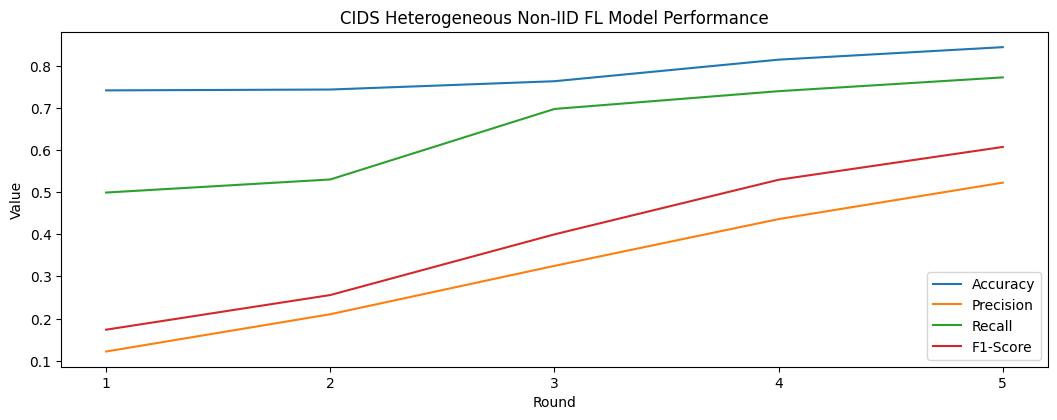

In [19]:
# Plotting model performance results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds1 = np.arange(1, len(fl_global_accuracies) + 1)
plt.plot(rounds1, fl_global_accuracies, label='Accuracy')
plt.plot(rounds1, fl_global_precisions, label='Precision')
plt.plot(rounds1, fl_global_recalls, label='Recall')
plt.plot(rounds1, fl_global_f1s, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

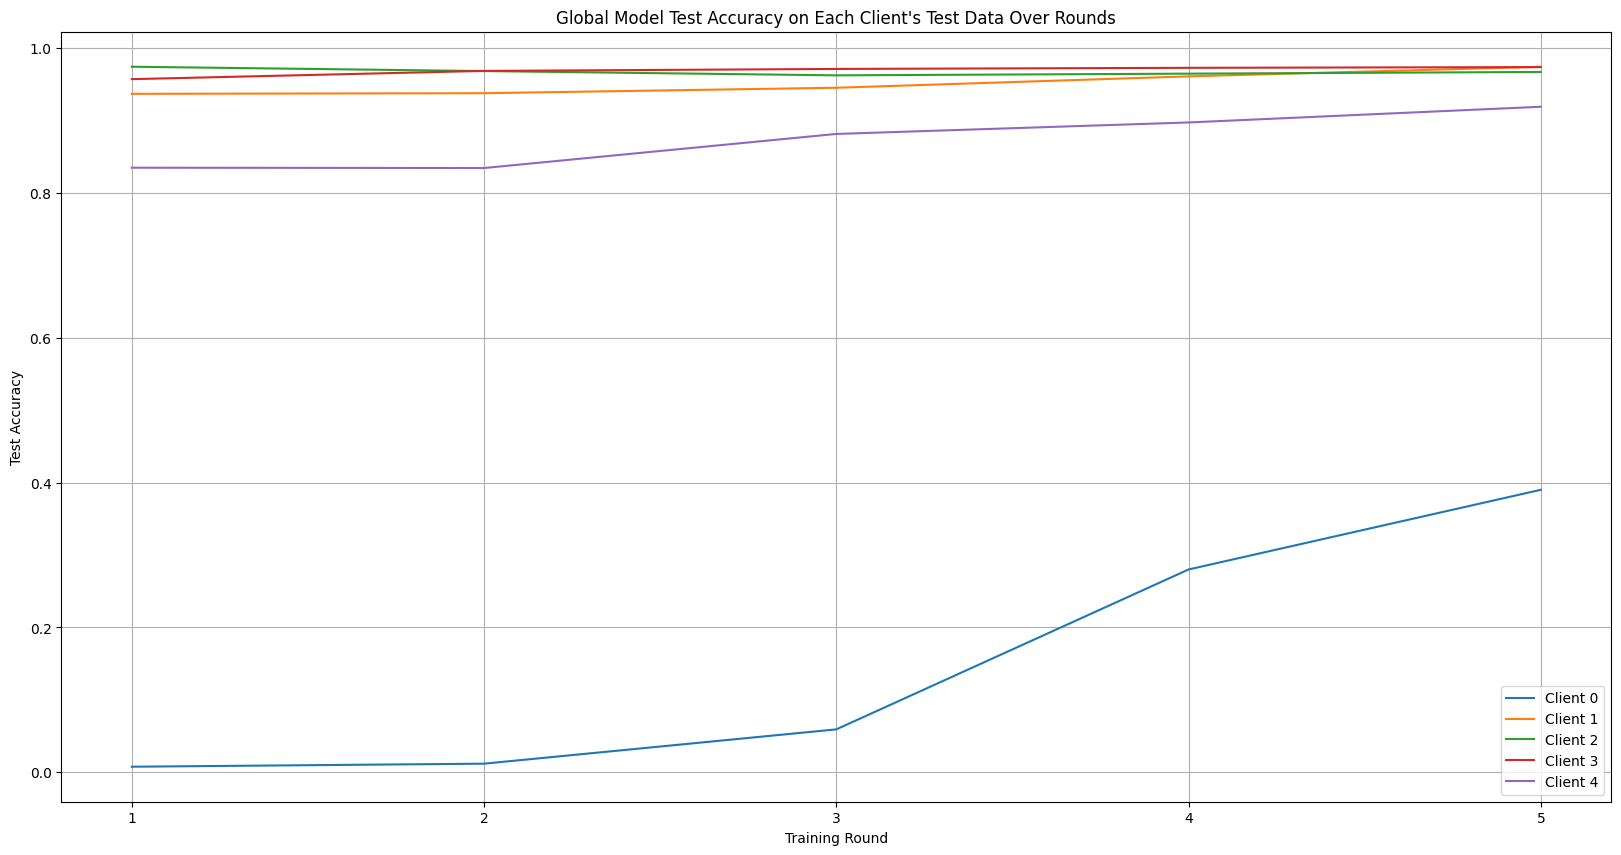

In [31]:
# Visualization of test accuracy over rounds
num_rounds = 5
plt.figure(figsize=(20, 10))
for client_id, accuracies in test_accuracies_per_client.items():
    plt.plot(range(1, num_rounds + 1), accuracies, label=f'Client {client_id}')

plt.xlabel('Training Round')
plt.ylabel('Test Accuracy')
plt.title('Global Model Test Accuracy on Each Client\'s Test Data Over Rounds')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()

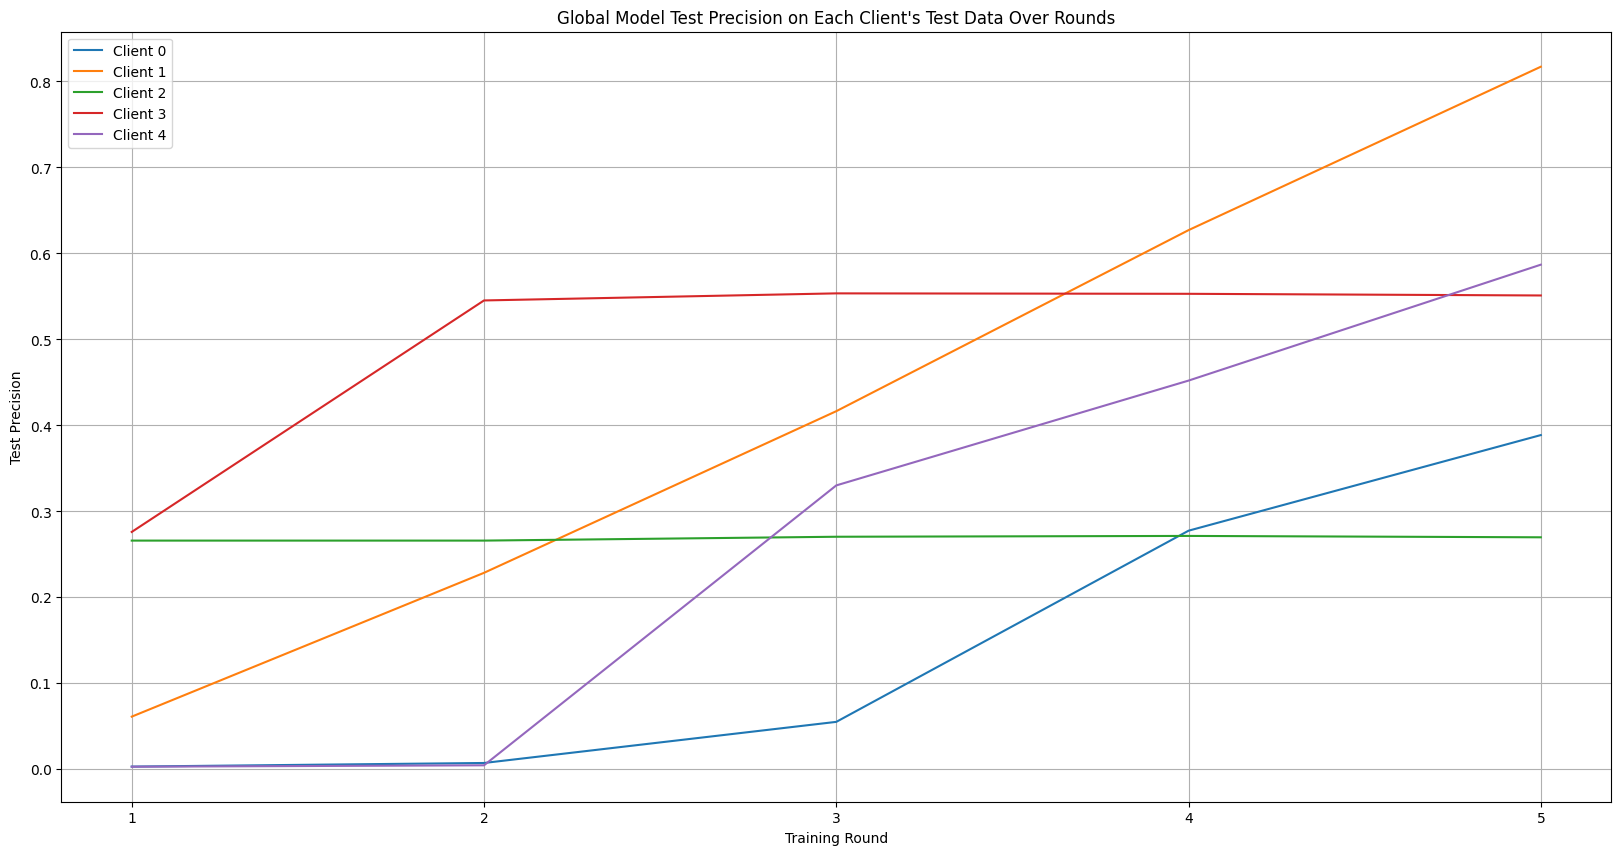

In [32]:
# Visualization of test precision over rounds
num_rounds = 5
plt.figure(figsize=(20, 10))
for client_id, precisions in test_precisions_per_client.items():
    plt.plot(range(1, num_rounds + 1), precisions, label=f'Client {client_id}')

plt.xlabel('Training Round')
plt.ylabel('Test Precision')
plt.title('Global Model Test Precision on Each Client\'s Test Data Over Rounds')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()

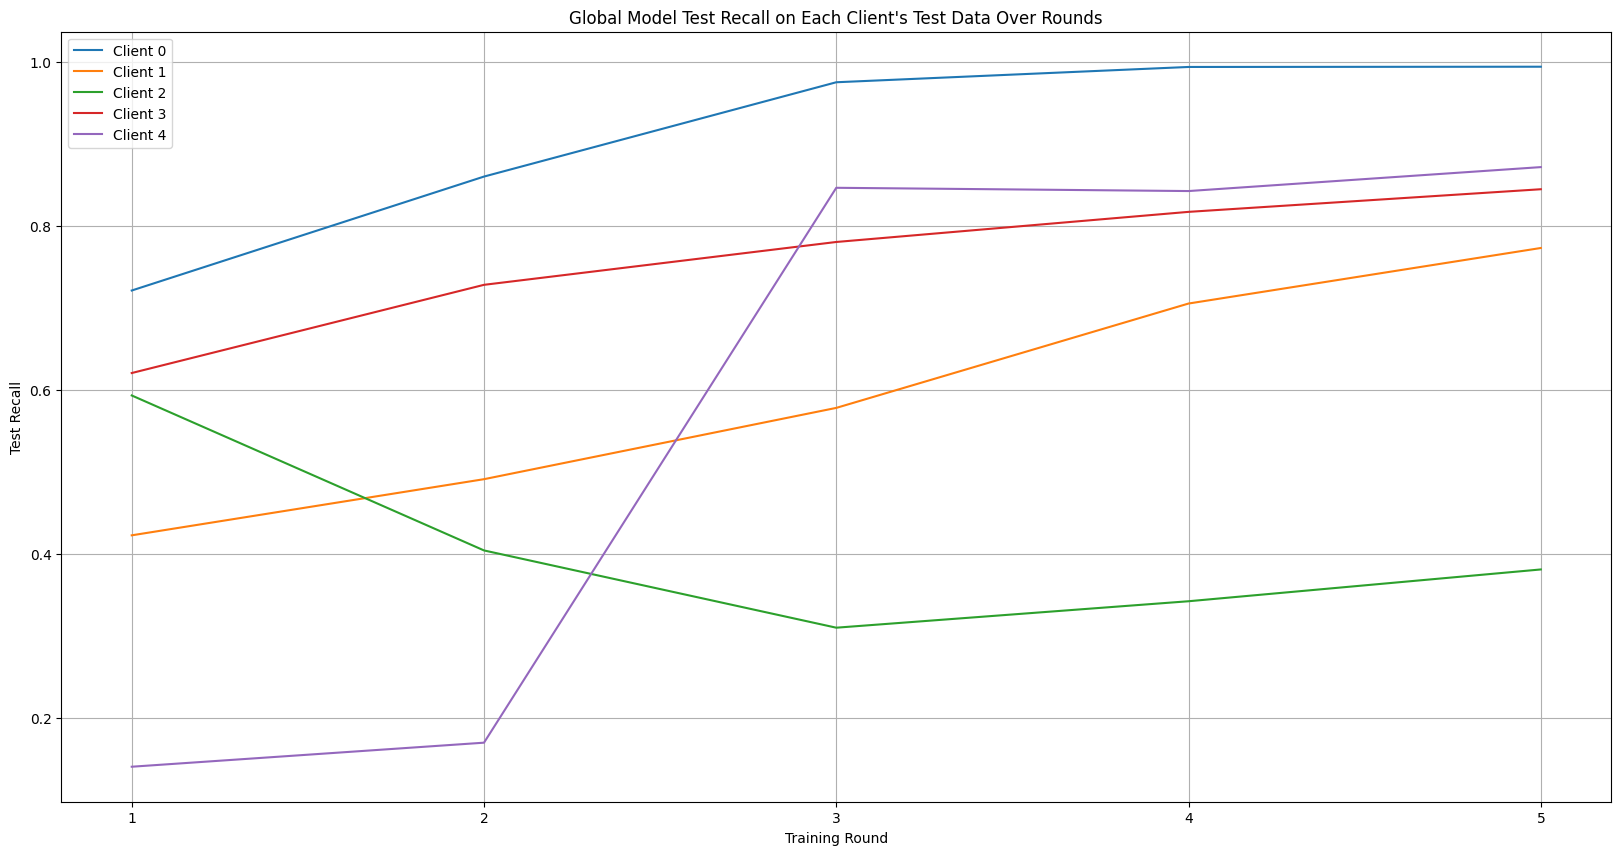

In [33]:
# Visualization of test recall over rounds
num_rounds = 5
plt.figure(figsize=(20, 10))
for client_id, recalls in test_recalls_per_client.items():
    plt.plot(range(1, num_rounds + 1), recalls, label=f'Client {client_id}')

plt.xlabel('Training Round')
plt.ylabel('Test Recall')
plt.title('Global Model Test Recall on Each Client\'s Test Data Over Rounds')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()

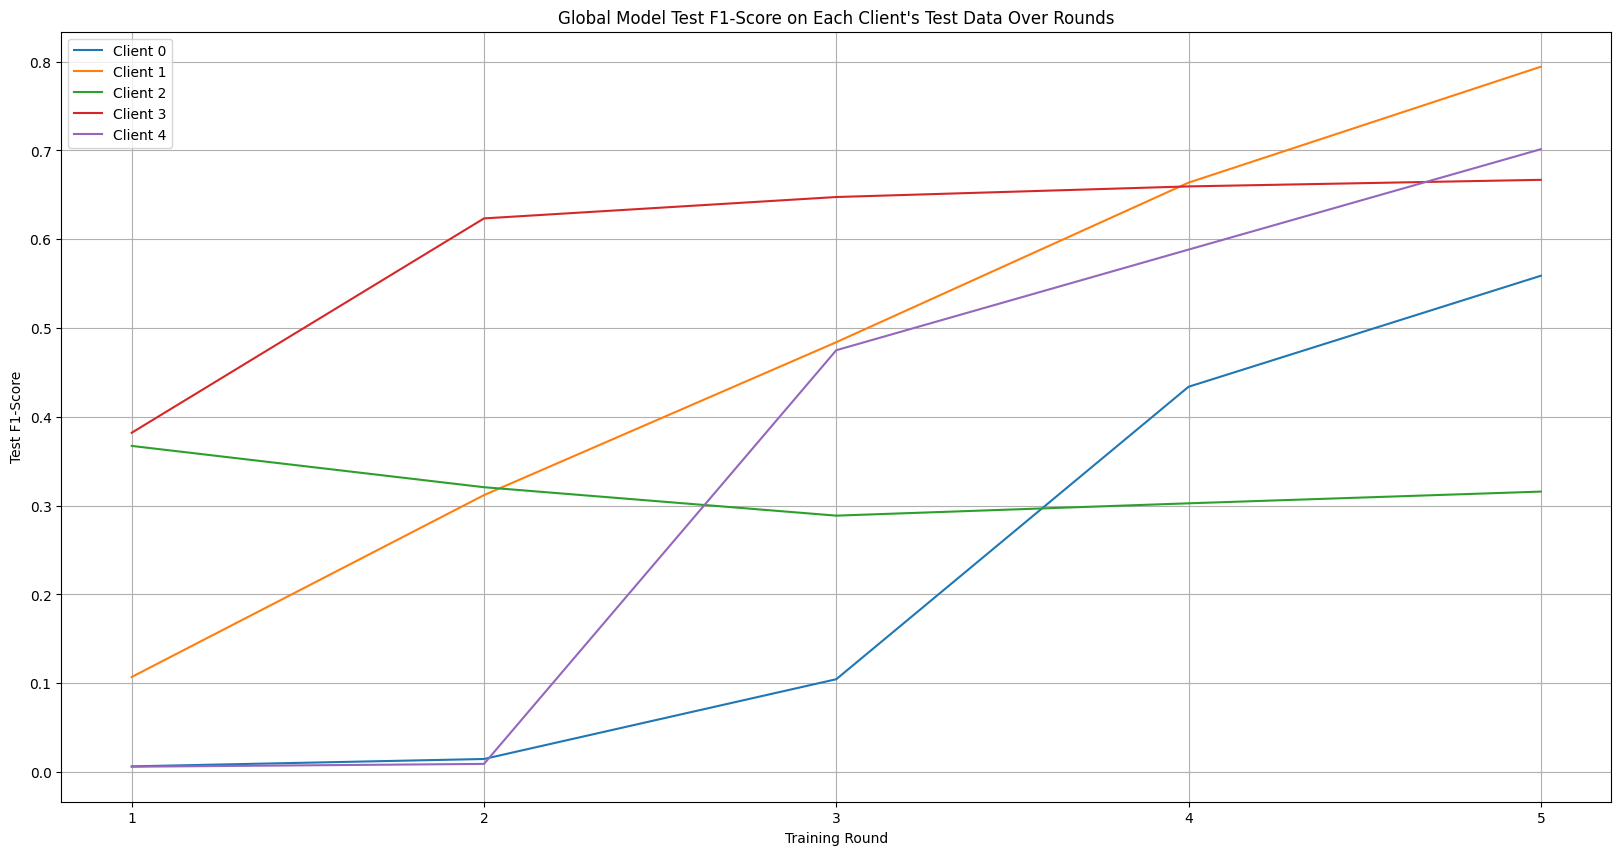

In [34]:
# Visualization of test f1 over rounds
num_rounds = 5
plt.figure(figsize=(20, 10))
for client_id, f1s in test_f1s_per_client.items():
    plt.plot(range(1, num_rounds + 1), f1s, label=f'Client {client_id}')

plt.xlabel('Training Round')
plt.ylabel('Test F1-Score')
plt.title('Global Model Test F1-Score on Each Client\'s Test Data Over Rounds')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()

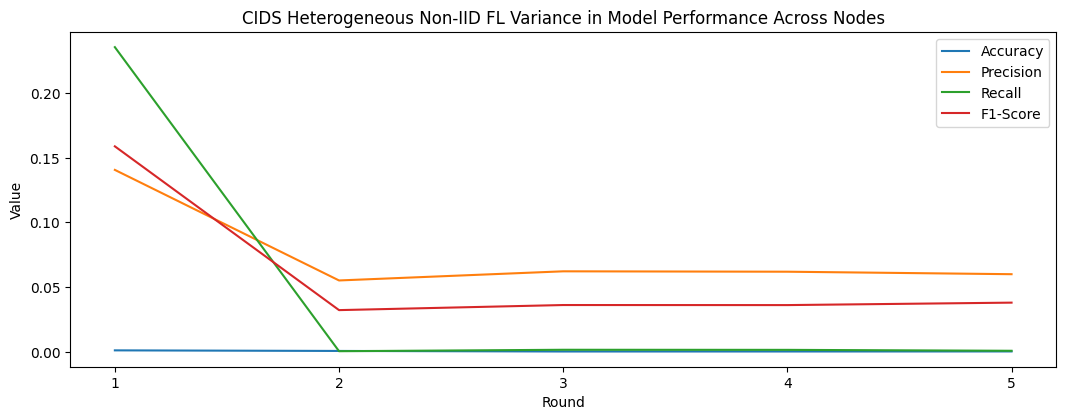

In [24]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds2 = np.arange(1, len(accuracy_variances) + 1)
plt.plot(rounds2, accuracy_variances, label='Accuracy')
plt.plot(rounds2, precision_variances, label='Precision')
plt.plot(rounds2, recall_variances, label='Recall')
plt.plot(rounds2, f1_variances, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Variance in Model Performance Across Nodes')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

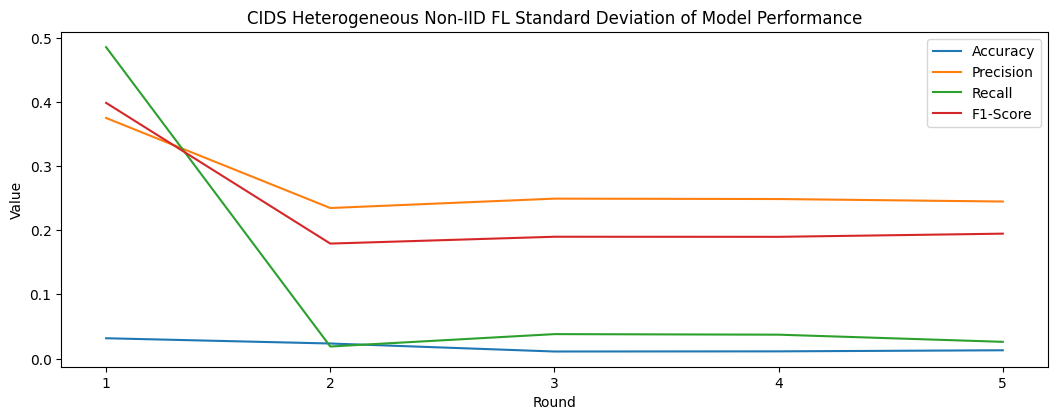

In [25]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds3 = np.arange(1, len(accuracy_stds) + 1)
plt.plot(rounds3, accuracy_stds, label='Accuracy')
plt.plot(rounds3, precision_stds, label='Precision')
plt.plot(rounds3, recall_stds, label='Recall')
plt.plot(rounds3, f1_stds, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Standard Deviation of Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

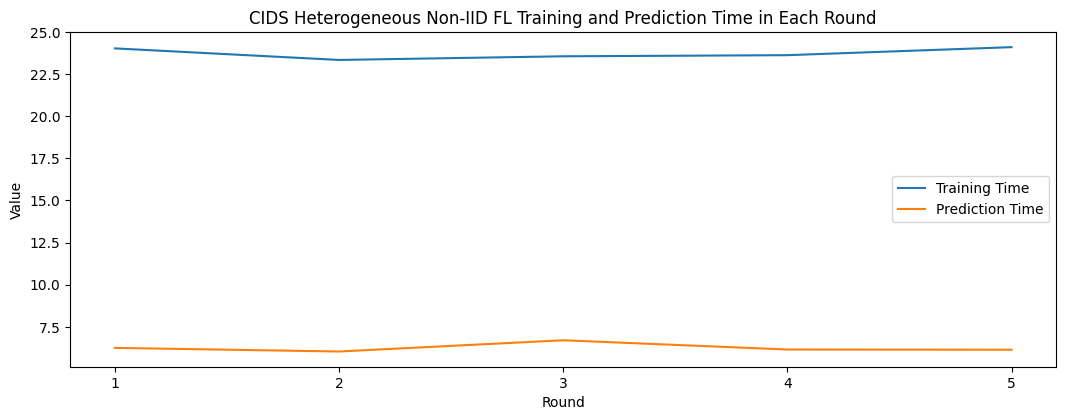

In [26]:
# Plotting training and prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds4 = np.arange(1, len(total_training_times) + 1)
plt.plot(rounds4, total_training_times, label='Training Time')
plt.plot(rounds4, total_prediction_times, label='Prediction Time')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Training and Prediction Time in Each Round')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

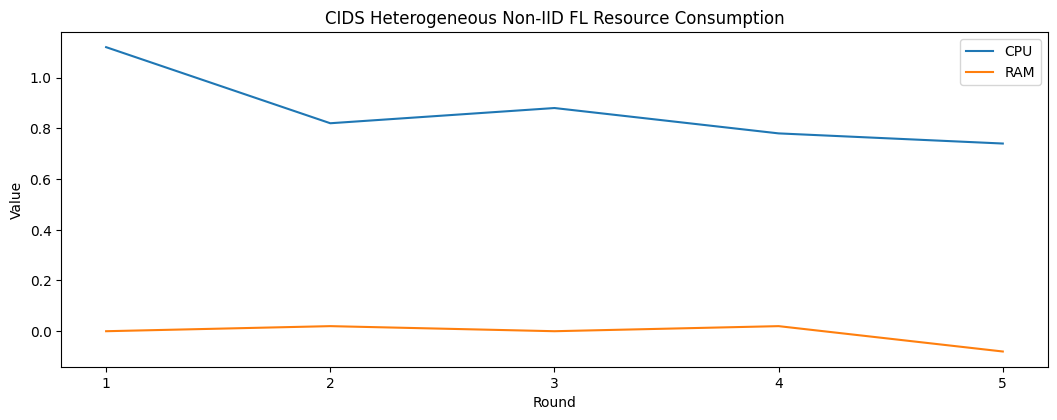

In [27]:
# Plotting resource consumption
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds5 = np.arange(1, len(cpu_usages) + 1)
plt.plot(rounds5, cpu_usages, label='CPU')
plt.plot(rounds5, memory_usages, label='RAM')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Resource Consumption')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

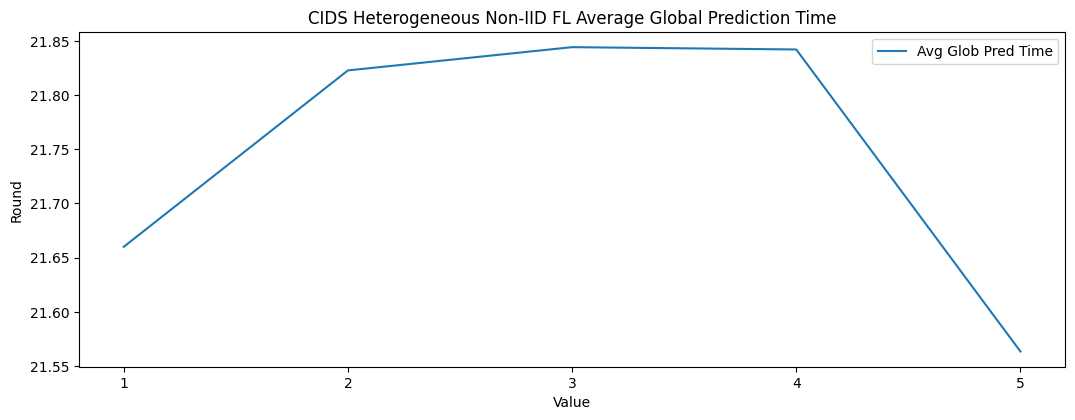

In [28]:
# Plotting global prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds6 = np.arange(1, len(global_pred_times) + 1)
plt.plot(rounds6, global_pred_times, label='Avg Glob Pred Time')
plt.ylabel('Round')
plt.xlabel('Value')
plt.title('CIDS Heterogeneous Non-IID FL Average Global Prediction Time')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

In [36]:
# Number of rounds
rounds = list(range(1, len(fl_global_accuracies) + 1))

# Save global performance metrics with rounds
global_metrics_df = pd.DataFrame({
    "Round": rounds,
    "Global Accuracy": fl_global_accuracies,
    "Global Precision": fl_global_precisions,
    "Global Recall": fl_global_recalls,
    "Global F1-Score": fl_global_f1s,
    "Global Prediction Time": global_pred_times,
    "Total Training Times": total_training_times,
    "Total Prediction Times": total_prediction_times,
    "CPU Usage": cpu_usages,
    "Memory Usage": memory_usages,
    "Accuracy Variance": accuracy_variances,
    "Precision Variance": precision_variances,
    "Recall Variance": recall_variances,
    "F1 Variance": f1_variances,
    "Accuracy Std": accuracy_stds,
    "Precision Std": precision_stds,
    "Recall Std": recall_stds,
    "F1 Std": f1_stds
})

# Export global metrics to a CSV
global_metrics_df.to_csv("global_performance_metrics.csv", index=False)

# Save client-specific metrics across rounds with rounds as rows
test_accuracies_df = pd.DataFrame(test_accuracies_per_client)
test_precisions_df = pd.DataFrame(test_precisions_per_client)
test_recalls_df = pd.DataFrame(test_recalls_per_client)
test_f1s_df = pd.DataFrame(test_f1s_per_client)

# Add round information as a column
test_accuracies_df.insert(0, "Round", rounds)
test_precisions_df.insert(0, "Round", rounds)
test_recalls_df.insert(0, "Round", rounds)
test_f1s_df.insert(0, "Round", rounds)

# Export each client metric to a separate CSV
test_accuracies_df.to_csv("test_accuracies_per_client.csv", index=False)
test_precisions_df.to_csv("test_precisions_per_client.csv", index=False)
test_recalls_df.to_csv("test_recalls_per_client.csv", index=False)
test_f1s_df.to_csv("test_f1s_per_client.csv", index=False)

print("All metrics exported to CSV files successfully.")

All metrics exported to CSV files successfully.
